## Setup & Data Loading

In [2]:
print("Installing required packages...")
%pip install yfinance > /dev/null 2>&1
%pip install torch torchvision torchaudio > /dev/null 2>&1
%pip install python-dotenv > /dev/null 2>&1
%pip install seaborn > /dev/null 2>&1
print("All packages installed.")

Installing required packages...
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
All packages installed.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import requests
import time
import seaborn as sns

# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import OneClassSVM


# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
 
import yfinance as yf

/Users/jasonyi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Datasets + Preprocessing

### 1: S&P500 - Yahoo Finance

In [4]:
# s&p500
symbol = "^GSPC"

# Time range
start_date = "2000-01-01"
end_date = "2025-04-09"

In [5]:
data = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True)
yfinance_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()
yfinance_returns

[*********************100%***********************]  1 of 1 completed


Ticker,^GSPC
Date,
2000-01-04,-0.039099
2000-01-05,0.001920
2000-01-06,0.000955
2000-01-07,0.026730
2000-01-10,0.011128
...,...
2025-04-02,0.006706
2025-04-03,-0.049606
2025-04-04,-0.061609


### 2: Alpha Vantage API
[Alpha Vantage API Documentation](https://www.alphavantage.co/documentation/#dailyadj)

In [6]:
load_dotenv()
function = "TIME_SERIES_DAILY"
api_key = os.getenv("ALPHA_VANTAGE_API_KEY")
symbols = ["META", "AMZN", "AAPL", "NFLX", "GOOG", "MSFT", "NVDA"]

In [7]:
def fetch_alpha_vantage(symbol):
    response = requests.get(
        f"https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize=full&apikey={api_key}"
    )
    json_data = response.json()
    return parse(json_data)

def parse(json_data):
    ts_key = "Time Series (Daily)"
    raw_data = json_data[ts_key]
    df = pd.DataFrame.from_dict(raw_data, orient="index")

    # Rename columns
    df.rename(columns={
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. volume": "volume"
    }, inplace=True)

    # Convert index to datetime and sort
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Convert column types
    df = df.astype({
        "open": float,
        "high": float,
        "low": float,
        "close": float,
        "volume": int
    })

    return df

In [8]:
# Dictionary to store daily log returns for each stock
alpha_vantage_returns = {}

for symbol in symbols:
    df_vantage = fetch_alpha_vantage(symbol)
    vantage_returns = np.log(df_vantage["close"] / df_vantage["close"].shift(1)).dropna()
    alpha_vantage_returns[symbol] = vantage_returns

# To check, print a few examples
print(alpha_vantage_returns["META"].head())
print(alpha_vantage_returns["AAPL"].head())

vantage_returns

KeyError: 'Time Series (Daily)'

### 3: NASDAQ - Polygon.io

In [9]:
load_dotenv()
polygon_api_key = os.getenv("POLYGON_API_KEY")
ticker = 'I:COMP' # NASDAQ
url = f'https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/2024-01-01/2025-01-01?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}'



In [10]:
response = requests.get(url)
data = response.json()

# Extract close prices and timestamps
closes = [item['c'] for item in data['results']]
timestamps = [item['t'] for item in data['results']]

# Convert timestamps to readable dates
dates = pd.to_datetime(timestamps, unit='ms')

# Compute daily log returns
polygon_returns = np.diff(np.log(closes))
polygon_returns

array([-1.18352811e-02, -5.62912303e-03,  9.48750731e-04,  2.17726397e-02,
        9.38751318e-04,  7.50590897e-03,  3.57635852e-05,  1.71961060e-04,
       -1.89942933e-03, -5.95472443e-03,  1.33748472e-02,  1.68162184e-02,
        3.21589007e-03,  4.26538149e-03,  3.62203217e-03,  1.84419756e-03,
       -3.56083909e-03,  1.11109310e-02, -7.58869169e-03, -2.25533594e-02,
        1.29486319e-02,  1.72516307e-02, -2.00324591e-03,  7.25577802e-04,
        9.41455910e-03,  2.34991858e-03,  1.23930070e-02, -3.01370429e-03,
       -1.81627241e-02,  1.29177549e-02,  2.96092439e-03, -8.23941519e-03,
       -9.22565577e-03, -3.19837599e-03,  2.91428140e-02, -2.79652504e-03,
       -1.28686473e-03,  3.68928503e-03, -5.47554846e-03,  9.00041513e-03,
        1.13091663e-02, -4.15192960e-03, -1.66688625e-02,  5.75238347e-03,
        1.49721609e-02, -1.16361613e-02, -4.10155737e-03,  1.52620268e-02,
       -5.41680957e-03, -3.04812870e-03, -9.67903815e-03,  8.12272915e-03,
        3.92579758e-03,  

## Exploratory Analysis

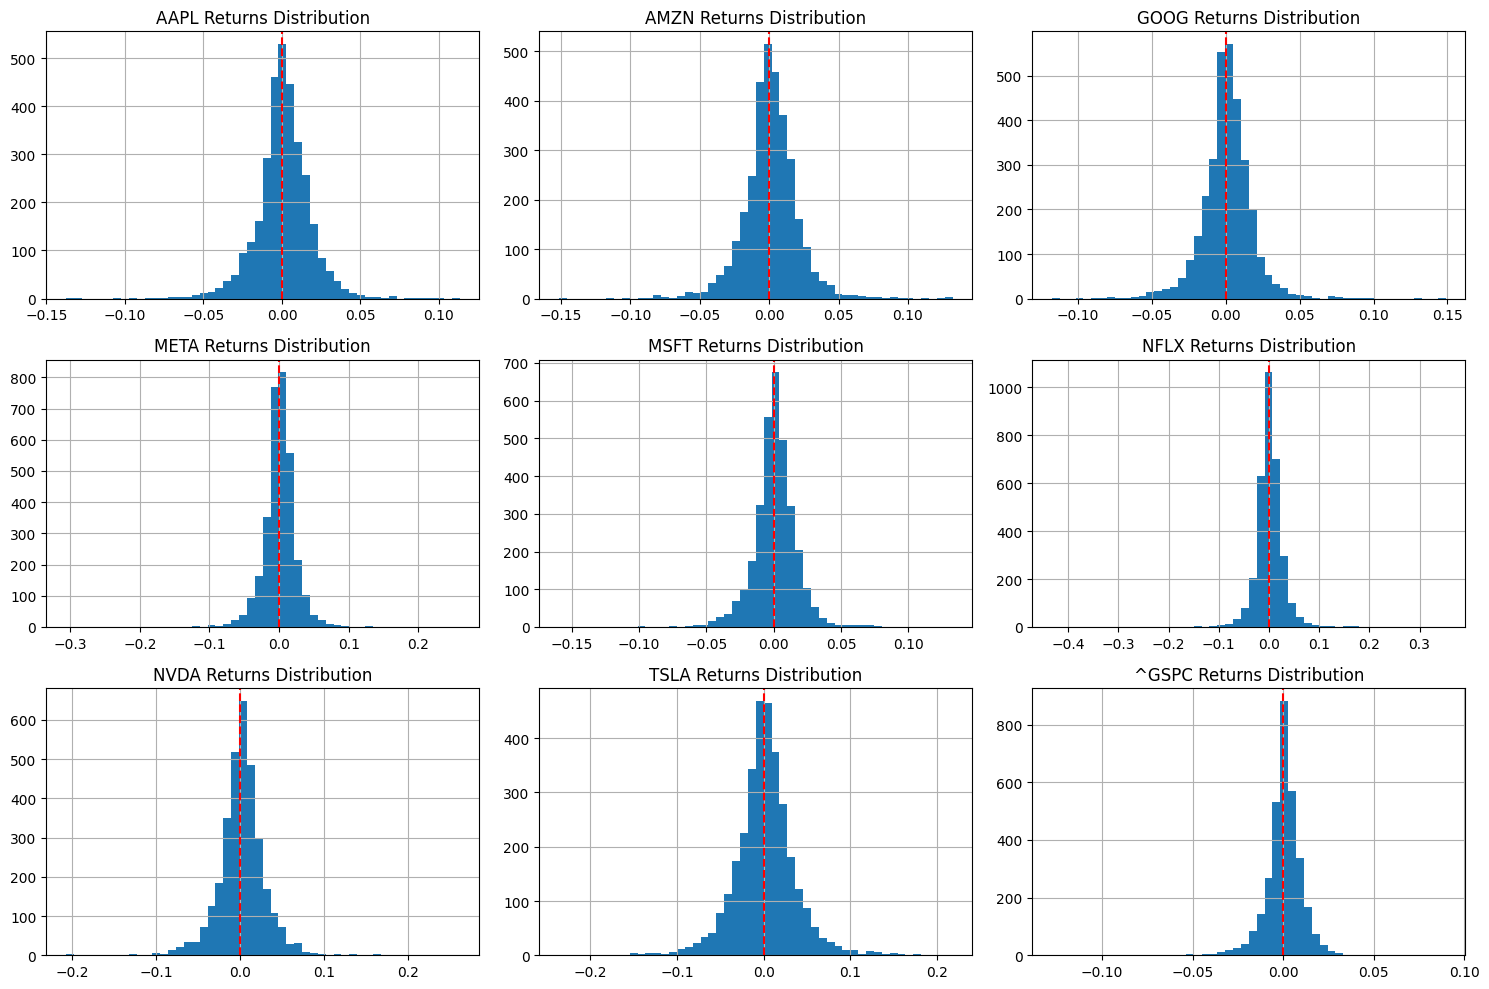

In [13]:
# Simple histograms
plt.figure(figsize=(15, 10))
for i, symbol in enumerate(yfinance_returns.columns):
    plt.subplot(3, 3, i+1)
    yfinance_returns[symbol].hist(bins=50)
    plt.title(f'{symbol} Returns Distribution')
    plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()

* All distributions show more concentration around the mean (the peak) and fatter tails than a normal distribution would have.
* excess kurtosis-> financial markets
* All distributions are centered close to zero, aligned with the efficient market hypothesis that predicts stock returns should center around zero in the short term.

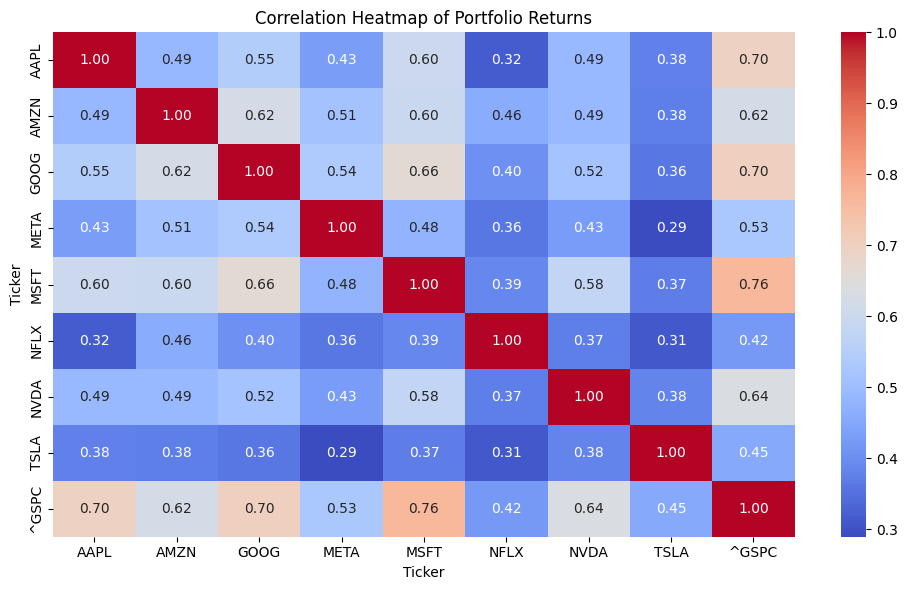

In [14]:
# === Correlation Matrix ===
plt.figure(figsize=(10, 6))
sns.heatmap(yfinance_returns.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Portfolio Returns")
plt.tight_layout()
plt.show()

* For each stock, we have the daily log returns: log(today's price / yesterday's price)-> the correlation measures how these returns move together day by day.
* Overall, most correlations are positive and moderate to strong (0.3-0.7 range), indicating that these tech stocks generally move together.
* The average correlation appears to be around 0.5, suggesting approximately half of the movement in these stocks is explained by common factors
* The S&P 500 (^GSPC) shows the strongest average correlation with individual stocks, which is expected as it represents the broader market
* MSFT (0.76), AAPL (0.70), and GOOG (0.70) have the strongest relationships with the S&P 500

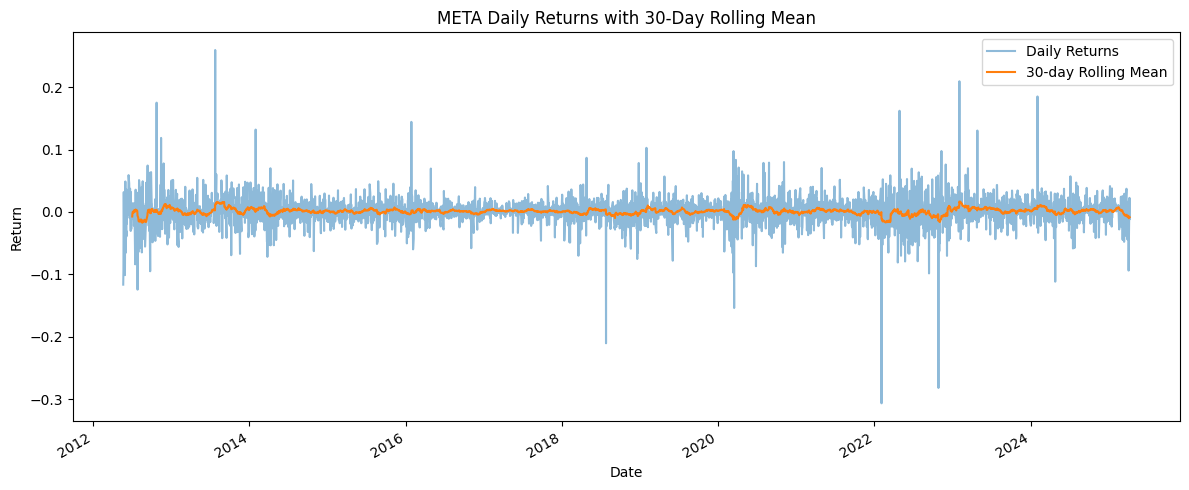

In [37]:
# === Time Series of META Returns (Yahoo) ===
plt.figure(figsize=(12, 5))
yfinance_returns["META"].plot(label="Daily Returns", alpha=0.5)
yfinance_returns["META"].rolling(window=30).mean().plot(label="30-day Rolling Mean")
plt.title("META Daily Returns with 30-Day Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()

Analysis of META Daily Returns:

*   **Volatility:** The daily returns (blue line) exhibit significant volatility, characterized by frequent and sometimes large fluctuations around zero. This is typical for stock returns.

*   **Rolling Mean:** The 30-day rolling mean (orange line) provides a smoothed view of the trend. It stays relatively close to zero but shows periods of slight positive or negative drift, indicating shifts in the medium-term average return.

*   **Outliers:** Several sharp spikes (both positive and negative) in the daily returns represent days with unusually large price movements (high volatility events or potential outliers).

*   **Clustering:** Periods of higher volatility appear to cluster together (e.g., around 2020 and 2022-2023), a common phenomenon in financial markets known as volatility clustering.

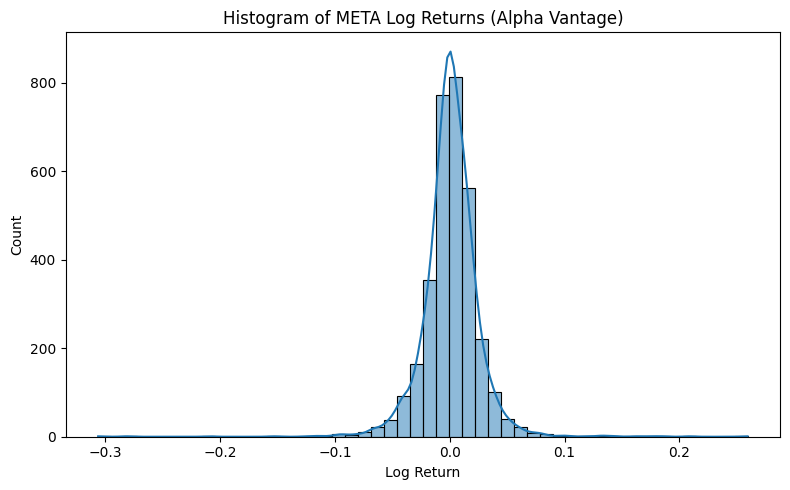

In [16]:
# === Histogram of META Returns from Alpha Vantage ===
plt.figure(figsize=(8, 5))
sns.histplot(vantage_returns, bins=50, kde=True)
plt.title("Histogram of META Log Returns (Alpha Vantage)")
plt.xlabel("Log Return")
plt.tight_layout()
plt.show()

Analysis of META Log Returns Histogram (Alpha Vantage):

*   **Central Tendency:** The histogram is sharply peaked around zero, indicating that the most frequent daily log return for META is very close to zero.

*   **Shape & Kurtosis:** The distribution appears roughly symmetric and bell-shaped, but with a higher peak and potentially fatter tails than a standard normal distribution (leptokurtic). This suggests a higher concentration of returns near the mean and a greater likelihood of extreme returns (outliers) than predicted by a normal distribution.

*   **Spread:** The bulk of the returns fall within a relatively narrow range (e.g., approximately -0.05 to +0.05), but the tails extend further out, showing occasional larger daily price movements.

*   **Consistency:** This shape is characteristic of financial asset returns, often exhibiting near-zero means and leptokurtosis.

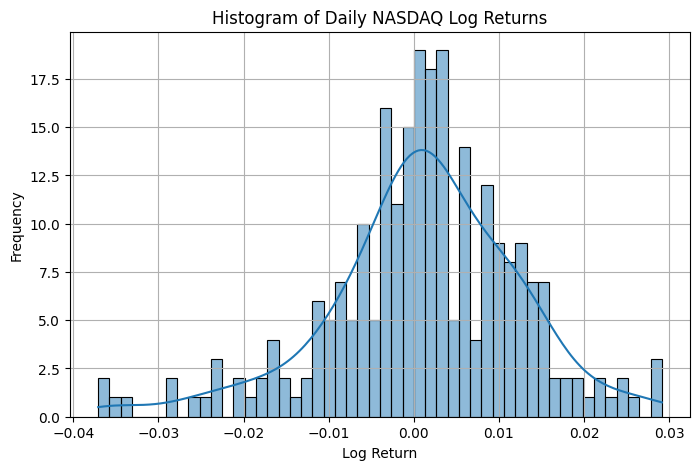

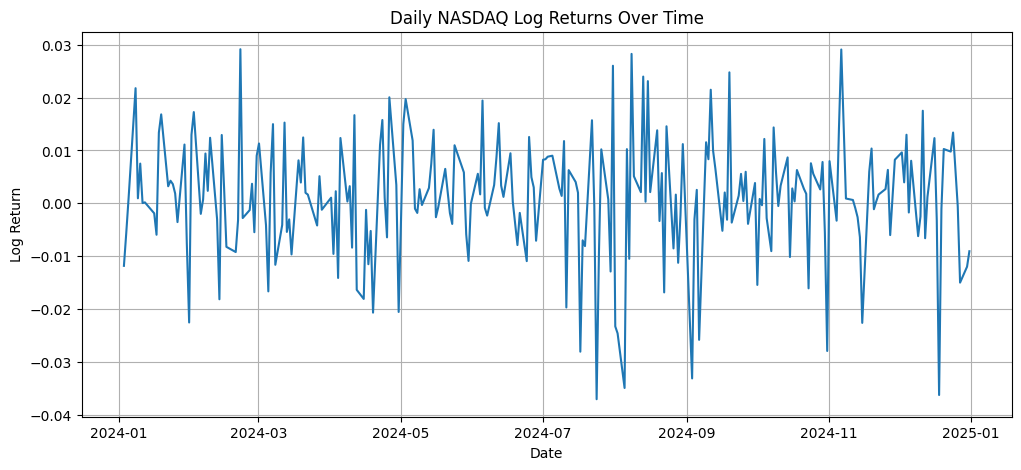

In [17]:
plt.figure(figsize=(8,5))
sns.histplot(polygon_returns, bins=50, kde=True)
plt.title('Histogram of Daily NASDAQ Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(dates[1:], polygon_returns)
plt.title('Daily NASDAQ Log Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()

Histogram of Daily NASDAQ Returns
* The returns are roughly bell-shaped but have fat tails, indicating more frequent extreme returns than a normal distribution would predict.
* There’s a slight left skew, suggesting larger or more frequent negative returns compared to positive ones.

Time Series of Daily NASDAQ Returns
* Returns fluctuate around zero but show periods of high volatility clustering, where large swings happen close together.
* Several sharp spikes (both positive and negative) are visible, indicating market shocks or major news events.

## Outlier Detection

In [15]:
def detect_outliers_iqr(data, threshold=1.5):
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1
  return (data < q1 - threshold*iqr) | (data > q3 + threshold*iqr)

def detect_outliers_zscore(series, threshold=3):
    z = (series - series.mean()) / series.std()
    return np.abs(z) > threshold


In [16]:
def plot_outliers(series, name='Data', method='iqr', threshold=3):
  if isinstance(series, np.ndarray):
      index = np.arange(len(series))  # simple index if no dates
  else:
      index = series.index

  if method == 'iqr':
      mask = detect_outliers_iqr(series)
  elif method == 'zscore':
      mask = detect_outliers_zscore(series, threshold)
  elif method == 'iso':
      iso = IsolationForest(contamination=0.05, random_state=42)
      preds = iso.fit_predict(series.reshape(-1, 1) if isinstance(series, np.ndarray) else series.values.reshape(-1, 1))
      mask = preds == -1
  else:
      raise ValueError("Method must be one of: 'iqr', 'zscore', 'iso'")

  plt.figure(figsize=(14, 4))
  plt.plot(index, series if isinstance(series, np.ndarray) else series.values, label='Returns')
  plt.scatter(index[mask], (series if isinstance(series, np.ndarray) else series.values)[mask], color='red', label='Outliers')
  plt.title(f"{name} - Outliers detected by {method.upper()}")
  plt.legend()
  plt.grid(True)
  plt.show()

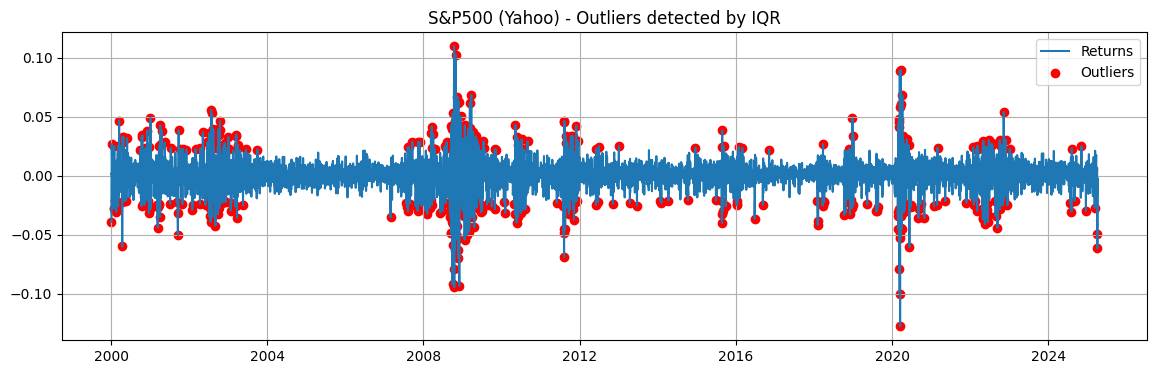

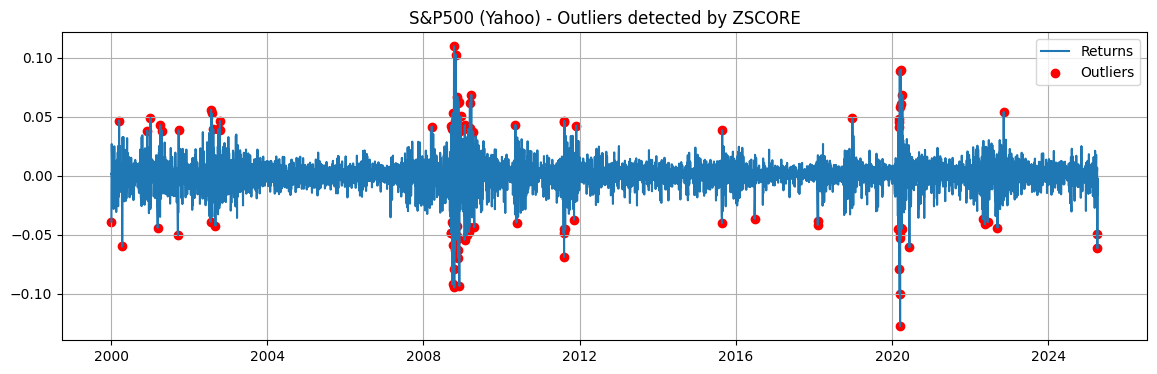

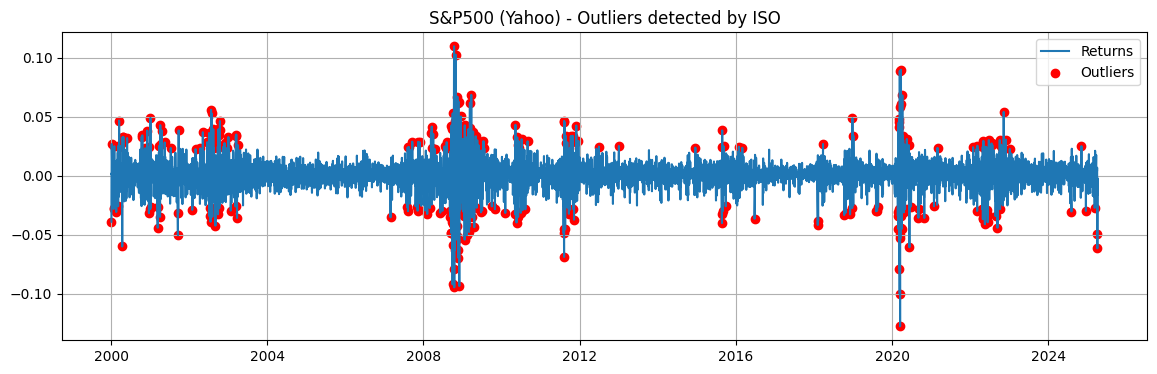

In [14]:
plot_outliers(yfinance_returns['^GSPC'], name='S&P500 (Yahoo)', method='iqr')
plot_outliers(yfinance_returns['^GSPC'], name='S&P500 (Yahoo)', method='zscore')
plot_outliers(yfinance_returns['^GSPC'], name='S&P500 (Yahoo)', method='iso')

**IQR (Interquartile Range)**: Detects a **large number of outliers**, capturing both extreme and moderate return spikes especially around major market crashes (2008, 2020).

**Z-Score**: Flags **only the most extreme return days**, resulting in **fewer outliers** and focusing mainly on severe market shocks.

**Isolation Forest (ISO)**: **Balances** sensitivity by identifying both **sharp jumps** and **periods of sustained volatility**, not just the highest peaks.

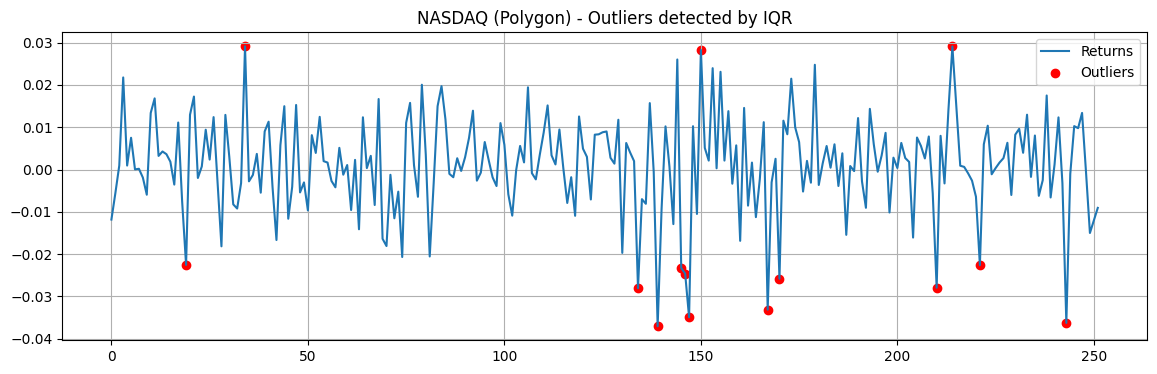

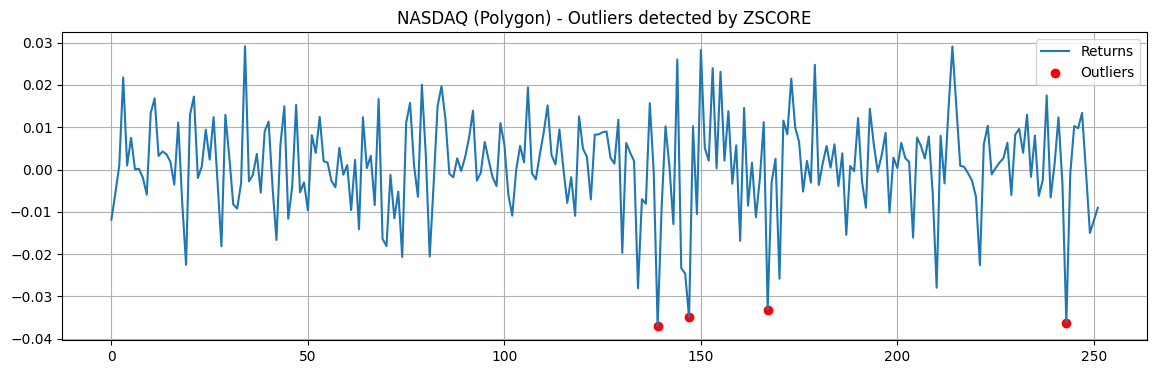

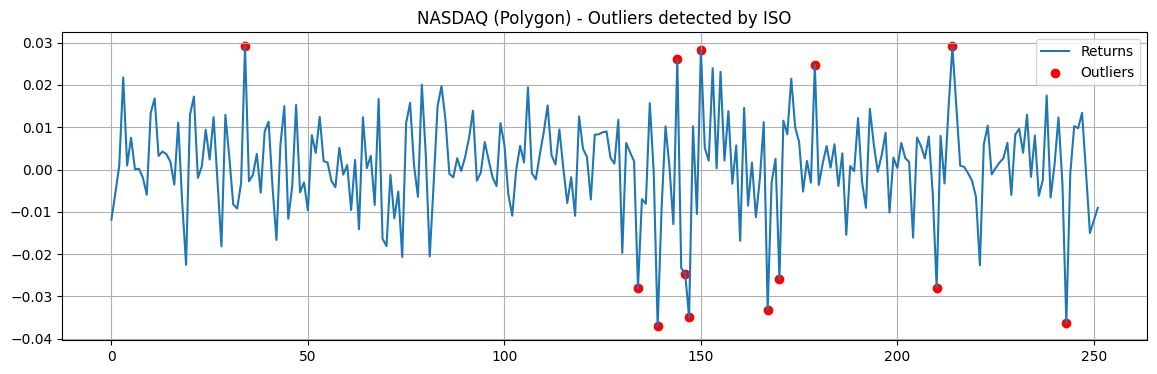

In [17]:
plot_outliers(polygon_returns, name='NASDAQ (Polygon)', method='iqr')
plot_outliers(polygon_returns, name='NASDAQ (Polygon)', method='zscore')
plot_outliers(polygon_returns, name='NASDAQ (Polygon)', method='iso')

**IQR (Interquartile Range)**: 14 anomalies

**Z-Score**: 4 anomalies

**Isolation Forest (ISO)**: 13 anomalies

In [ ]:
# Plot outliers for META
plot_outliers(vantage_returns["META"], name="META (Alpha Vantage)", method="iqr")
plot_outliers(vantage_returns["META"], name="META (Alpha Vantage)", method="zscore")
plot_outliers(vantage_returns["META"], name="META (Alpha Vantage)", method="iso")

## Uncovering Latent Structures: PCA vs Nonlinear PCA (Autoencoder)

Here, we will combine the datasets Yahoo Finance (S&P500) and individual tech stocks from Alpha Vantage by simply using Yahoo Finance, combining both S&P500 and individual tech stocks

In [12]:
# S&P500 and individual tech stocks
symbols = [
    '^GSPC',
    'META',
    'AMZN',
    'AAPL',
    'NFLX',
    'GOOG',
    'MSFT',
    'NVDA',
    'TSLA'
]

start_date = "2000-01-01"
end_date = "2025-04-09"

# Download data
data = yf.download(symbols, start=start_date, end=end_date, auto_adjust=True)

# Compute daily log returns
yfinance_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()

[*********************100%***********************]  9 of 9 completed


### Traditional PCA

In [13]:
# Traditional PCA Analysis
X_scaled = StandardScaler().fit_transform(yfinance_returns)

# Fit PCA
pca = PCA(n_components=3)
pca_factors = pca.fit_transform(X_scaled)
pca_returns_df = pd.DataFrame(pca_factors, index=yfinance_returns.index, columns=["f1", "f2", "f3"])

In [14]:
pca_exposures_df = pd.DataFrame(index=yfinance_returns.columns, columns=["f1", "f2", "f3"]).astype(float)

for asset in yfinance_returns.columns:
    lr = LinearRegression()
    lr.fit(pca_returns_df, yfinance_returns[asset].values)
    pca_exposures_df.loc[asset] = lr.coef_

In [15]:
# returns a vector of explained variance by each component
pct = pca.explained_variance_ratio_

# get the influence each component has on the features
pca_components = pca.components_

(0.0, 100.0)

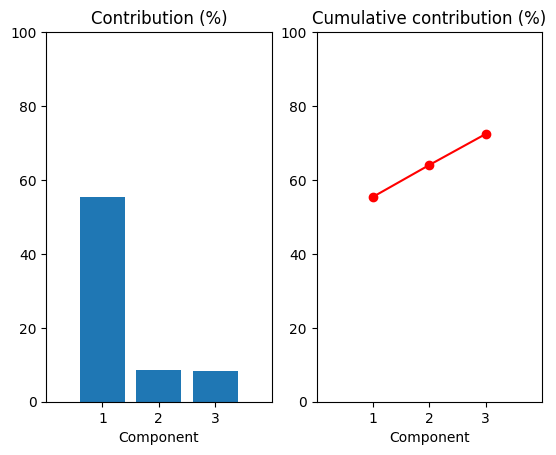

In [16]:
# plotting
cum_pct = np.cumsum(pct)
x = np.arange(1, len(pct)+1, 1)

plt.subplot(1, 2, 1)
plt.bar(x, pct * 100, align="center")
plt.title("Contribution (%)")
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

plt.subplot(1, 2, 2)
plt.plot(x, cum_pct * 100, 'ro-')
plt.title('Cumulative contribution (%)')
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

*   **Contribution Plot (Left):**
    *   The first principal component (Component 1) explains the vast majority of the variance in the dataset, accounting for approximately 55%.
    *   The second and third components (Component 2 and Component 3) explain significantly less variance, each contributing around 8-9%.

*   **Cumulative Contribution Plot (Right):**
    *   Component 1 alone captures about 55% of the total variance.
    *   Adding Component 2 brings the cumulative explained variance to roughly 64% (55% + 9%).
    *   Including Component 3 increases the cumulative explained variance to approximately 73% (64% + 9%).
    
*   **Interpretation:**
    *   A large portion of the movement in these stock returns can be attributed to a single dominant factor (captured by Component 1), likely representing broad market or sector trends.
    *   The first three components together capture nearly three-quarters of the total variance, suggesting that a 3-factor model provides a reasonable, though not complete, representation of the underlying data structure.

In [17]:
# multiply returns by components and transpose the dataframe
X = np.asarray(yfinance_returns)

factor_returns = X.dot(pca_components.T)

# recall that we set n_components=3 earlier to denote how many principal components we want
factor_returns = pd.DataFrame(
    columns=["f1", "f2", "f3"],
    index=yfinance_returns.index,
    data=factor_returns
)

factor_returns.head()

,f1,f2,f3
Date,,,
2012-05-21,0.034164,0.016855,0.077611
2012-05-22,-0.045160,-0.000968,0.111989
2012-05-23,0.044159,0.041568,-0.025642
2012-05-24,-0.021177,-0.024789,-0.023859
2012-05-25,-0.020887,-0.004525,0.010102


In [18]:
# plot the portfolio returns influenced by the first factor
factor_exposures = pd.DataFrame(
    index=["f1", "f2", "f3"],
    columns=yfinance_returns.columns,
    data = pca_components
).T

factor_exposures

,f1,f2,f3
Ticker,,,
AAPL,0.336531,-0.299887,0.223877
AMZN,0.349491,0.099142,-0.228253
GOOG,0.365492,-0.151456,-0.155371
META,0.305070,-0.031316,-0.398382
MSFT,0.372971,-0.237662,0.016928
NFLX,0.260592,0.733538,-0.376198
NVDA,0.330440,-0.062035,0.142907
TSLA,0.251986,0.492392,0.735975
^GSPC,0.397804,-0.188305,0.105065


Text(0.5, 1.0, 'Asset Loadings on Principal Component 1')

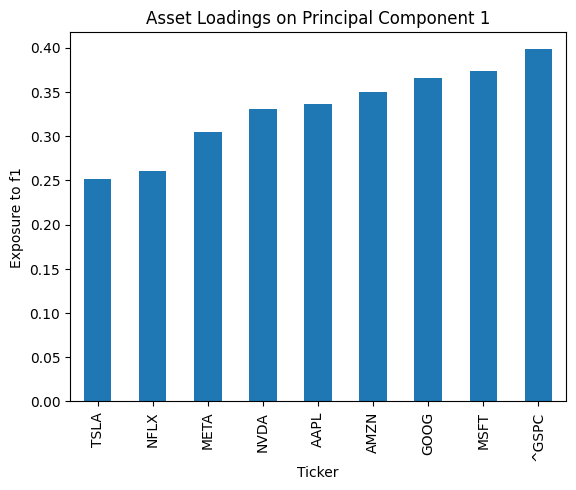

In [19]:
factor_exposures.f1.sort_values().plot.bar()
plt.ylabel("Exposure to f1")
plt.title("Asset Loadings on Principal Component 1")

The bar chart plots the loadings (or exposures) of the first principal component (f1) across all the assets in the portfolio (including ^GSPC, AAPL, MSFT, etc.).

These values represent how much each asset contributes to the first principal component, which typically captures the largest source of variance in the dataset.

Analysis:
* TSLA, NVDA, and NFLX have high positive exposures to the first principal component, suggesting they are strongly aligned with the main factor driving portfolio variance.

* ^GSPC (S&P 500) has the lowest exposure, meaning its behavior is less influenced by this main factor compared to the others.

* This makes sense—^GSPC is a broad market index, often more diversified and stable.

* Stocks like AAPL, MSFT, GOOG are in the middle — they move with the first factor, but not as strongly as TSLA or NVDA.

* Given that tech/growth stocks (like TSLA, NVDA) dominate the top end, `f1` could be interpreted as a “growth/tech risk factor”.

Text(0.5, 1.0, 'Asset Loadings on Principal Component 2')

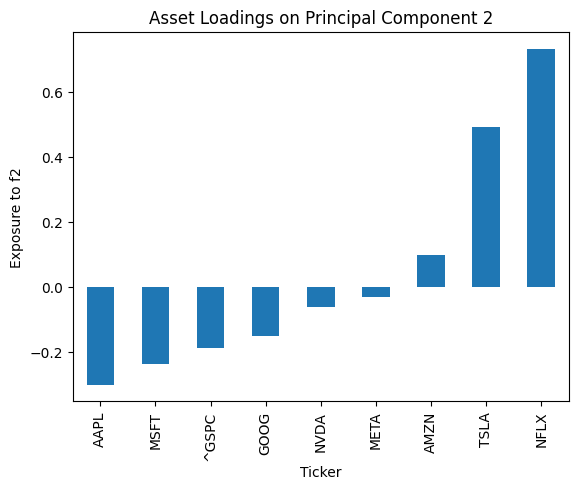

In [20]:
factor_exposures.f2.sort_values().plot.bar()
plt.ylabel("Exposure to f2")
plt.title("Asset Loadings on Principal Component 2")

TSLA loads heavily positive on f2, and several other tech stocks like NFLX, META, NVDA load negatively, while the rest (including the index) are near neutral.

`f2` might capture a unique risk or return profile specific to TSLA, such as:
* Idiosyncratic volatility or momentum (TSLA often behaves very differently from even other tech stocks) - most likely due to recent political events
* A "speculative growth" factor (TSLA being the face of that in recent years)

Text(0.5, 1.0, 'Asset Loadings on Principal Component 3')

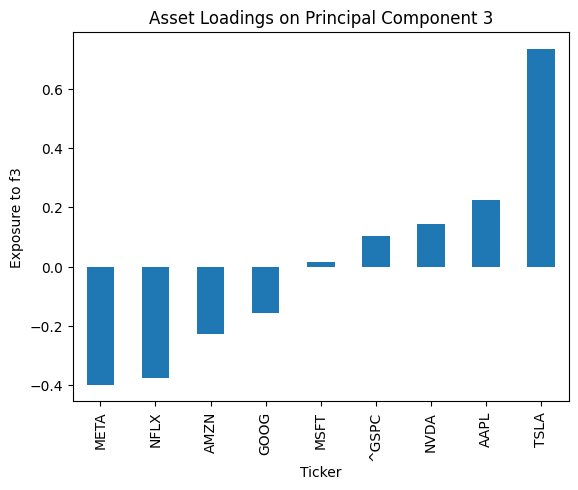

In [21]:
factor_exposures.f3.sort_values().plot.bar()
plt.ylabel("Exposure to f3")
plt.title("Asset Loadings on Principal Component 3")

From the plot:
* NFLX has a very strong positive exposure to f3 (~0.85+)
* NVDA has a strong negative exposure (~-0.4)
* META, AAPL, MSFT, GOOG, etc. have mild to moderate negative exposures
* TSLA and AMZN are slightly positive

This kind of distribution suggests that f3 might represent a volatility or risk sentiment factor — for example:
* High positive exposure (NFLX): Might reflect a unique return pattern or idiosyncratic risk (e.g., high beta, high growth, high volatility).
* High negative exposure (NVDA, META): Suggests an opposite movement — perhaps NVDA's price movements diverge from those of NFLX in this principal component's dimension.
* Other large-cap stocks are close to neutral or slightly negative.



### Autoencoder

We will define our model in the following ways:
* Architecture: Encoder: input -> 128 neurons -> latent; Decoder: latent -> 128 neurons -> input
* Objective: MSE loss during training
* Latent Representation: `latent = self.encoder(x)` -> 3D representation
* Optimization: Adam optimizer used in training loop

In [22]:
# Defining Autoencoder (PyTorch)
class Autoencoder(nn.Module):
  def __init__(self, input_dim, latent_dim):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, latent_dim)
    )
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.ReLU(),
        nn.Linear(128, input_dim)
    )

  def forward(self, x):
    latent = self.encoder(x)
    reconstructed = self.decoder(latent)
    return reconstructed, latent

In [23]:
# Standardize the returns data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(yfinance_returns)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

In [24]:
input_dim = X_tensor.shape[1]  # e.g., 10 stocks
latent_dim = 3                 # same as n_components in PCA

model = Autoencoder(input_dim, latent_dim)

In [25]:
# training
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    recon, z = model(X_tensor)
    loss = loss_fn(recon, X_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.0064
Epoch 100, Loss: 0.2525
Epoch 200, Loss: 0.2265
Epoch 300, Loss: 0.2093
Epoch 400, Loss: 0.1975
Epoch 500, Loss: 0.1891
Epoch 600, Loss: 0.1843
Epoch 700, Loss: 0.1796
Epoch 800, Loss: 0.1756
Epoch 900, Loss: 0.1737


In [26]:
# Extract latent features
with torch.no_grad():
    _, factor_returns = model(X_tensor)

factor_returns_df = pd.DataFrame(
    factor_returns.numpy(),
    index=yfinance_returns.index,
    columns=["f1", "f2", "f3"]
)

factor_exposures_df = factor_exposures_df = pd.DataFrame(index=yfinance_returns.columns, columns=["f1", "f2", "f3"]).astype(float)

for asset in yfinance_returns.columns:
    lr = LinearRegression()
    lr.fit(factor_returns_df, yfinance_returns[asset].values)
    factor_exposures_df.loc[asset] = lr.coef_

factor_exposures_df

,f1,f2,f3
Ticker,,,
AAPL,0.006193,-0.001130,-0.001557
AMZN,0.006332,0.004343,-0.000014
GOOG,0.006455,0.002048,0.000063
META,0.008403,0.004746,0.002218
MSFT,0.006316,0.000799,-0.000502
NFLX,0.001323,0.011385,-0.005167
NVDA,0.008428,0.000373,-0.003813
TSLA,0.000318,0.003844,-0.013580
^GSPC,0.004006,0.000463,-0.000981


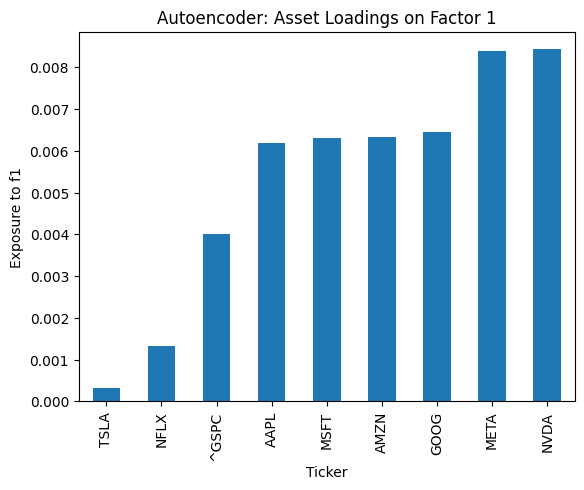

In [27]:
factor_exposures_df["f1"].sort_values().plot(kind='bar')
plt.ylabel("Exposure to f1")
plt.title("Autoencoder: Asset Loadings on Factor 1")
plt.show()

Analysis of Autoencoder Asset Loadings on Factor 1:

*   **General Trend:** This bar chart displays how each asset's returns relate to the first latent factor identified by the autoencoder. Most assets show a positive exposure, suggesting this factor captures a common trend, potentially related to overall market or tech sector movement, similar to PCA's first component but derived non-linearly.

*   **Highest Exposure:** TSLA exhibits the strongest positive loading, indicating its returns are most strongly associated with this primary latent factor. NVDA and NFLX follow with significant positive exposures.

*   **Lowest Exposure:** META is the only asset with a negative exposure, implying its returns, according to this factor, tend to move inversely compared to the others.

*   **Comparison to PCA:** While broadly similar to the PCA factor 1 in capturing a market/tech trend (most stocks load positively), the specific magnitudes and the negative loading for META highlight the differences introduced by the autoencoder's non-linear dimensionality reduction.

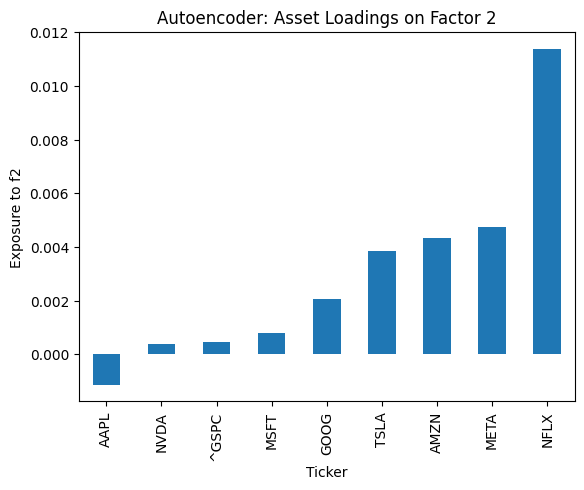

In [28]:
factor_exposures_df["f2"].sort_values().plot(kind='bar')
plt.ylabel("Exposure to f2")
plt.title("Autoencoder: Asset Loadings on Factor 2")
plt.show()

Analysis of Autoencoder Asset Loadings on Factor 2:

*   **Polarization:** This factor shows a clear split. NFLX and TSLA have strong positive loadings, while most other assets, including NVDA, AAPL, MSFT, GOOG, META, ^GSPC, and AMZN, have negative loadings.

*   **Interpretation:** Factor 2 appears to capture a dynamic that contrasts NFLX and TSLA against the broader tech group and the market index (^GSPC). This could relate to specific sub-sector trends, volatility profiles, or non-linear relationships that differentiate these two stocks from the others in the portfolio.

*   **Strongest Loadings:** NFLX and TSLA show the highest positive association with this factor, while NVDA and AAPL show the strongest negative association.

*   **Comparison to PCA:** Unlike PCA's factor 2 which strongly isolated TSLA, the autoencoder's factor 2 groups TSLA with NFLX and opposes them to a larger group including NVDA and AAPL, suggesting it's capturing different, potentially non-linear, underlying structures.

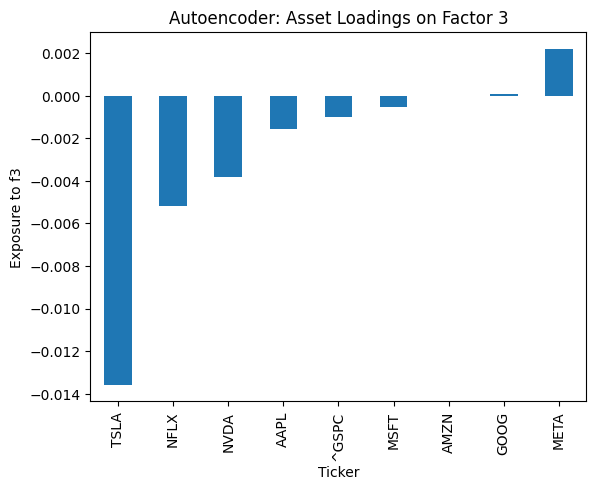

In [29]:
factor_exposures_df["f3"].sort_values().plot(kind='bar')
plt.ylabel("Exposure to f3")
plt.title("Autoencoder: Asset Loadings on Factor 3")
plt.show()

Analysis of Autoencoder Asset Loadings on Factor 3:

*   **Overall Negative Loadings:** All assets exhibit negative loadings on this third factor, although the magnitudes vary. This suggests the factor represents a dynamic that generally moves inversely to the returns of all stocks in the portfolio, but affects some more strongly than others.

*   **Strongest Loadings:** META and NFLX show the most significant negative exposures, indicating their returns are most strongly (inversely) related to this factor. AMZN, TSLA, and NVDA follow with substantial negative loadings.

*   **Weakest Loadings:** ^GSPC, AAPL, and MSFT have the least negative loadings, suggesting they are less influenced by this particular factor compared to META or NFLX.

*   **Interpretation:** This factor might capture a non-linear risk dimension or a specific market regime effect that negatively impacts tech stocks, particularly META and NFLX, more than others or the broader market (^GSPC). It's distinct from the primary trend (Factor 1) and the NFLX/TSLA vs. others split (Factor 2).

*   **Comparison to PCA:** PCA's factor 3 showed a strong positive loading for NFLX and negative for NVDA, contrasting them. The autoencoder's factor 3, however, groups all assets with negative loadings, highlighting a different underlying structure, potentially related to shared non-linear risks or specific event impacts.

### Comparing Metrics

In [30]:
results = []

for asset in yfinance_returns.columns:
    y_true = yfinance_returns[asset].values

    # Autoencoder prediction
    y_pred_ae = factor_returns_df.values @ factor_exposures_df.loc[asset].values
    r2_ae = r2_score(y_true, y_pred_ae)
    mse_ae = mean_squared_error(y_true, y_pred_ae)

    # PCA prediction
    y_pred_pca = pca_returns_df.values @ pca_exposures_df.loc[asset].values
    r2_pca = r2_score(y_true, y_pred_pca)
    mse_pca = mean_squared_error(y_true, y_pred_pca)

    results.append({
        "Ticker": asset,
        "R2_Autoencoder": r2_ae,
        "R2_PCA": r2_pca,
        "MSE_Autoencoder": mse_ae,
        "MSE_PCA": mse_pca
    })

comparison_df = pd.DataFrame(results).set_index("Ticker")

In [31]:
print(comparison_df.sort_values("R2_Autoencoder", ascending=False))

        R2_Autoencoder    R2_PCA  MSE_Autoencoder   MSE_PCA
Ticker                                                     
^GSPC         0.762597  0.823855         0.000027  0.000020
MSFT          0.678376  0.735480         0.000087  0.000072
GOOG          0.657938  0.700807         0.000101  0.000088
TSLA          0.630820  0.911949         0.000480  0.000114
NFLX          0.613443  0.860969         0.000337  0.000121
AAPL          0.612790  0.670950         0.000123  0.000104
AMZN          0.596031  0.654541         0.000164  0.000141
NVDA          0.579811  0.559143         0.000340  0.000357
META          0.521725  0.583821         0.000301  0.000262


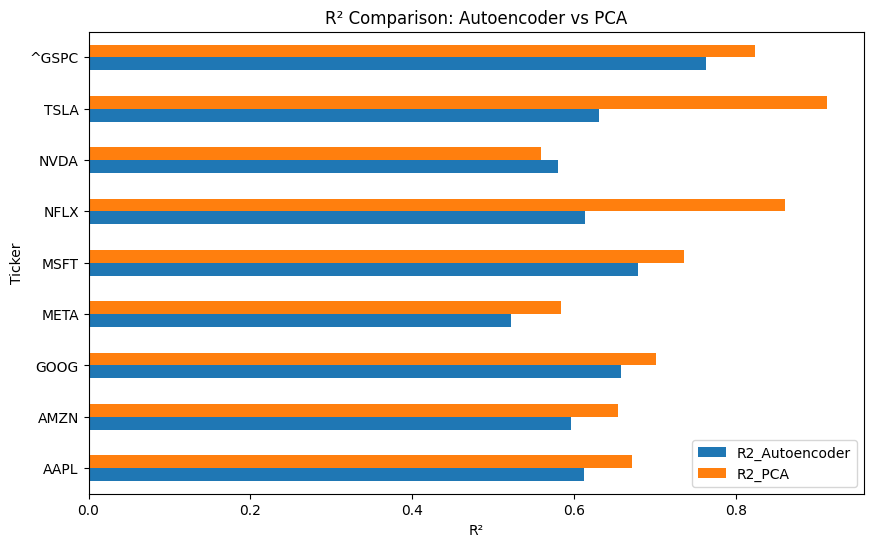

In [32]:
comparison_df[["R2_Autoencoder", "R2_PCA"]].plot(kind='barh', figsize=(10,6))
plt.title("R² Comparison: Autoencoder vs PCA")
plt.xlabel("R²")
plt.show()

Analysis:
* PCA consistently has higher R² for all assets — meaning it explains more variance in the returns.
* Even for nonlinear-looking assets like TSLA or NVDA, PCA still edges out the Autoencoder.
* For assets like ^GSPC, TSLA, and NFLX, PCA does significantly better.


In this specific setup, PCA outperforms the autoencoder in explaining asset return variance.

This might mean:
* Returns are fairly linear, and PCA is sufficient
* Autoencoder is underfitting (can be improved by deeper architecture, more training, or tuning)
* The autoencoder’s latent space isn't well-aligned with the factors driving return variance (which is okay — it's nonlinear!)

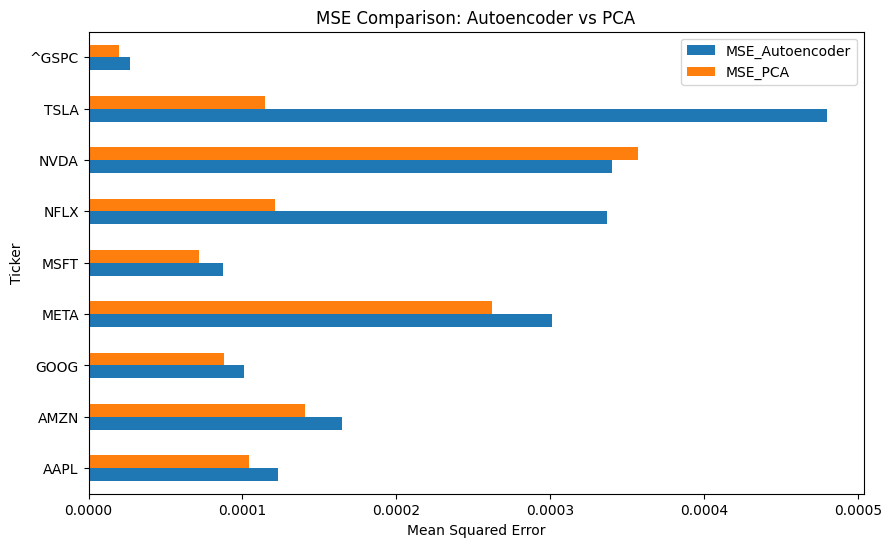

In [33]:
comparison_df[["MSE_Autoencoder", "MSE_PCA"]].plot(
    kind='barh', figsize=(10, 6), title="MSE Comparison: Autoencoder vs PCA"
)
plt.xlabel("Mean Squared Error")
plt.show()

Analysis:
* For every asset, PCA (orange) has a lower or equal MSE compared to Autoencoder (blue).
* This matches with the R² plot since Lower MSE ⟺ Higher R²
* TSLA, NVDA, NFLX: Autoencoder struggles most here — much higher MSE than PCA
* ^GSPC, GOOG, MSFT: Autoencoder performs relatively closer to PCA
* META, AAPL, AMZN: PCA still consistently does better, but the gap is smaller

## Clustering on Latent Features

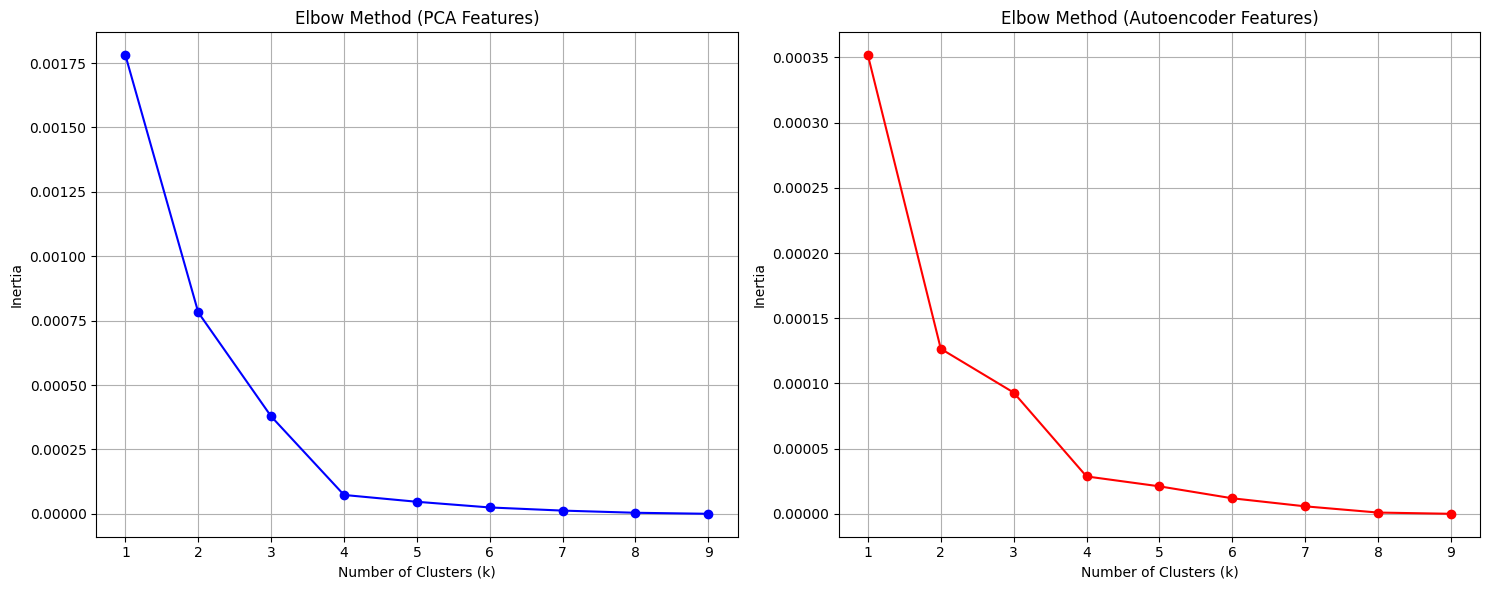

In [34]:
# Setup
k_range = range(1, 10)
pca_inertia = []
ae_inertia = []

# Calculate inertia for both methods
for k in k_range:
    # PCA clustering
    kmeans_pca = KMeans(n_clusters=k, random_state=42)
    kmeans_pca.fit(pca_exposures_df)
    pca_inertia.append(kmeans_pca.inertia_)
    
    # Autoencoder clustering
    kmeans_ae = KMeans(n_clusters=k, random_state=42)
    kmeans_ae.fit(factor_exposures_df)
    ae_inertia.append(kmeans_ae.inertia_)

# Create side-by-side plots
plt.figure(figsize=(15, 6))

# PCA plot
plt.subplot(1, 2, 1)
plt.plot(k_range, pca_inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method (PCA Features)')
plt.grid(True)

# Autoencoder plot
plt.subplot(1, 2, 2)
plt.plot(k_range, ae_inertia, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method (Autoencoder Features)')
plt.grid(True)

plt.tight_layout()
plt.show()

PCA-based clusters:
   Stock  Cluster
1   AMZN        0
3   META        0
5   NFLX        0
7   TSLA        1
0   AAPL        2
2   GOOG        2
4   MSFT        2
6   NVDA        2
8  ^GSPC        2

Autoencoder-based clusters:
   Stock  Cluster
1   AMZN        0
3   META        0
5   NFLX        1
7   TSLA        1
0   AAPL        2
2   GOOG        2
4   MSFT        2
6   NVDA        2
8  ^GSPC        2


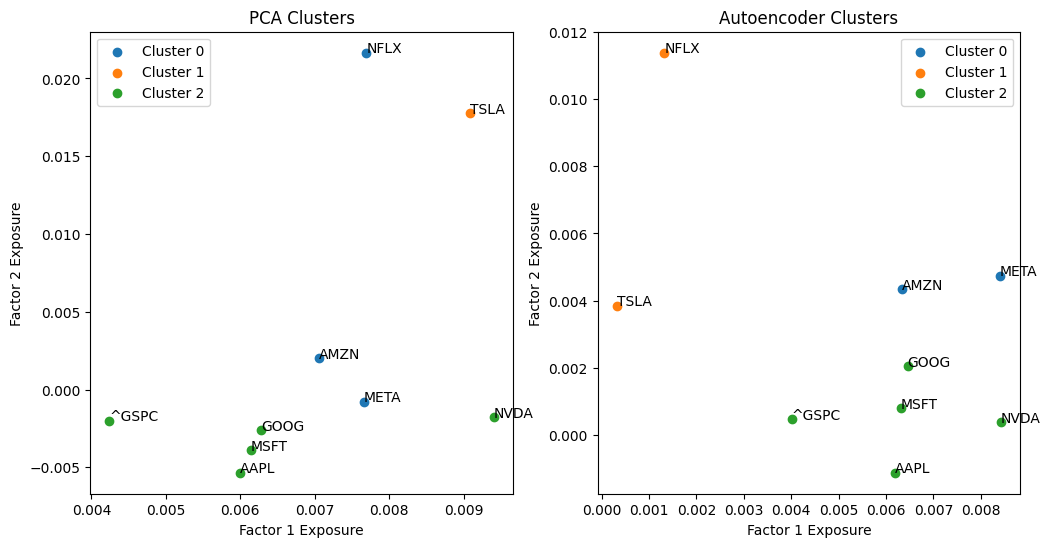

In [35]:

# Use PCA factor exposures as features for clustering
# This is simply the relationship between each stock and the 3 latent factors
n_clusters = 3  #same for both 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pca_clusters = kmeans.fit_predict(pca_exposures_df)
pca_cluster_results = pd.DataFrame({
    'Stock': yfinance_returns.columns,
    'Cluster': pca_clusters
})

print("PCA-based clusters:")
print(pca_cluster_results.sort_values('Cluster'))

# Similarly for autoencoder latent features
kmeans_ae = KMeans(n_clusters=n_clusters, random_state=42)
ae_clusters = kmeans_ae.fit_predict(factor_exposures_df)

# Create results dataframe
ae_cluster_results = pd.DataFrame({
    'Stock': yfinance_returns.columns,
    'Cluster': ae_clusters
})

print("\nAutoencoder-based clusters:")
print(ae_cluster_results.sort_values('Cluster'))

# Basic visualization
plt.figure(figsize=(12, 6))

# PCA clusters visualization - first 2 factors only for simplicity
plt.subplot(1, 2, 1)
for cluster in range(n_clusters):
    # Get stocks in this cluster
    cluster_stocks = pca_cluster_results[pca_cluster_results['Cluster'] == cluster]['Stock']
    # Plot their factor exposures
    plt.scatter(
        pca_exposures_df.loc[cluster_stocks, 'f1'],
        pca_exposures_df.loc[cluster_stocks, 'f2'],
        label=f'Cluster {cluster}'
    )
    # Label points with stock symbols
    for stock in cluster_stocks:
        plt.annotate(stock, (pca_exposures_df.loc[stock, 'f1'], pca_exposures_df.loc[stock, 'f2']))

plt.title('PCA Clusters')
plt.xlabel('Factor 1 Exposure')
plt.ylabel('Factor 2 Exposure')
plt.legend()

# Autoencoder clusters visualization
plt.subplot(1, 2, 2)
for cluster in range(n_clusters):
    # Get stocks in this cluster
    cluster_stocks = ae_cluster_results[ae_cluster_results['Cluster'] == cluster]['Stock']
    # Plot their factor exposures
    plt.scatter(
        factor_exposures_df.loc[cluster_stocks, 'f1'],
        factor_exposures_df.loc[cluster_stocks, 'f2'],
        label=f'Cluster {cluster}'
    )
    # Label points with stock symbols
    for stock in cluster_stocks:
        plt.annotate(stock, (factor_exposures_df.loc[stock, 'f1'], factor_exposures_df.loc[stock, 'f2']))

plt.title('Autoencoder Clusters')
plt.xlabel('Factor 1 Exposure')
plt.ylabel('Factor 2 Exposure')
plt.legend()

plt.show()